In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import h5py

In [2]:
def min_dist_angle(position, direction, box_size):
    #which wall is it close to?
    x, y = position
    dists = [box_size-x, box_size-y, box_size+x, box_size+y]
    d_wall = np.min(dists)
    angles = np.arange(4)*np.pi/2
    theta = angles[np.argmin(dists)]
    a_wall = direction - theta
    a_wall = (a_wall + np.pi) % (2*np.pi) - np.pi
    return d_wall, a_wall

In [3]:
def min_dist_angle_circular(position, direction, box_size):
    #which wall is it close to?
    x, y = position
    r = np.sqrt(x**2 + y**2)
    d_wall = box_size - r

    # find nearest point on circle
    x_circ = x*box_size / r
    y_circ = y*box_size / r

    # compute angle to this point
    theta = np.arctan2(y_circ, x_circ) % (2*np.pi)

    # subtract from head direction to get a_wall
    a_wall = direction - theta
    a_wall = (a_wall + np.pi) % (2*np.pi) - np.pi
    
    return d_wall, a_wall

In [42]:
dt = 0.02 #time step increment (seconds)
samples = int(200/dt) + 1 #number of time points
box_size = 2.2 / 2 #meters
border_region = 0.03 #meters

turn_angle = 0

mu = 0
sigma = 5.76 #stdev rotation velocity (rads/sec)
b = 0.13 #forward velocity rayleigh dist scale (m/sec)

In [43]:
# random velocity samples
def generate_trajectory():
    v = np.random.rayleigh(b);
    #initialize variables
    position = np.zeros([samples+1, 2])
    head_dir = np.zeros(samples+1)
    turning = np.zeros(samples+1, dtype='bool')
    
    position[0] = np.random.uniform(-box_size,box_size, 2)
#     position[0] = np.zeros(2) + 1e-4
    head_dir[0] = np.random.uniform(0,2*np.pi)
    ego_v = np.zeros(samples+1)
    
    #generate sequence of random boosts and turns
    random_turn = np.random.normal(mu, sigma, samples+1)
    random_vel = np.random.rayleigh(b, samples+1)
    
    for i in range(1,samples+1):
        #If in border region, turn and slow down
        d_wall, a_wall = min_dist_angle(position[i-1], head_dir[i-1] % (2*np.pi), box_size)
        if d_wall < border_region and np.abs(a_wall) < np.pi/2:
            turning[i-1] = 1 
            turn_angle = np.sign(a_wall)* (np.pi/2 - np.abs(a_wall)) + dt*random_turn[i]
            v -= 0.25*v
        else:
            v = random_vel[i]
            turn_angle = dt*random_turn[i]
        #Take a step
        ego_v[i-1] = v*dt
        position[i] = position[i-1] + ego_v[i-1]*np.asarray([np.cos(head_dir[i-1]), np.sin(head_dir[i-1])])
        #Rotate head direction
        head_dir[i] = (head_dir[i-1] + turn_angle) 
    ang_velocity = np.diff(head_dir)
    theta_x, theta_y = np.cos(ang_velocity), np.sin(ang_velocity)
    head_dir = (head_dir +np.pi) % (2*np.pi) - np.pi #Constrain head_dir to interval (-pi, pi)
    return position[:-1,0], position[:-1, 1], head_dir[:-1], ego_v[:-1], theta_x, theta_y, turning[:-1]

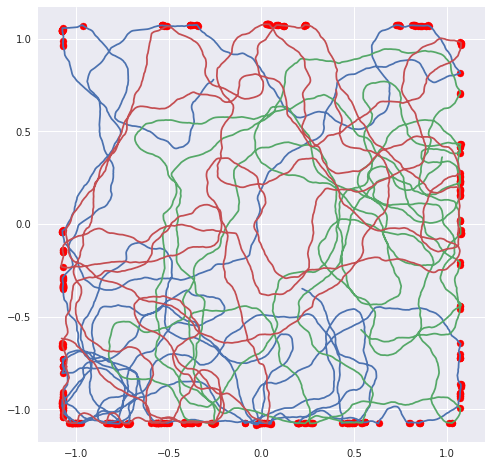

In [44]:
plt.figure(figsize=(8,8))
for i in range(3):
    sample_traj = generate_trajectory()
    x = sample_traj[0]
    y = sample_traj[1]
    turning = sample_traj[-1]
    plt.plot(x, y)
    plt.scatter(x[turning], y[turning], c='red')
    
plt.axis("equal")    
t = np.linspace(-np.pi, np.pi, 100)
# plt.plot(box_size*np.cos(t), box_size*np.sin(t))

In [45]:
traj[3].shape

(1000,)

In [48]:
# Generate dataset
def _floats_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

num_files = 10
num_trajectories = 100
for i in tqdm(range(num_files)):
    root = '/home/ec2-user/grid_cells/'
    filename = root + 'ben_decimate_1000_step/' + str(i+10) + '.tfrecord'
    with tf.python_io.TFRecordWriter(filename) as writer:
        for j in range(num_trajectories):
            traj = np.asarray(generate_trajectory())
            traj = traj[:,::10] # Decimate to approximately match deepmind

            feature = {
                'init_x': _floats_feature([traj[0][0]]),
                'init_y': _floats_feature([traj[1][0]]),
                'init_hd': _floats_feature([traj[2][0]]),
                'ego_v': _floats_feature(traj[3][:-1]),
                'theta_x': _floats_feature(traj[4][:-1]),
                'theta_y': _floats_feature(traj[5][:-1]),
                'target_x': _floats_feature(traj[0][1:]),
                'target_y': _floats_feature(traj[1][1:]),
                'target_hd': _floats_feature(traj[2][1:])
            }

            example = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example.SerializeToString())


In [7]:
#Generate dataset
num_trajectories = 800
x = []
y = []
head_dir = []
ego_v = []
theta_x = []
theta_y = []
i = 0
while len(x) < num_trajectories*samples - 1:
    new_traj = generate_trajectory()
#     if np.all(np.sqrt(new_traj[0]**2 + new_traj[1]**2) < 1.1):
    if np.all(np.abs(new_traj[0]) < 1.1) and np.all(np.abs(new_traj[1]) < 1.1):
        x = np.append(x, new_traj[0])
        y = np.append(y, new_traj[1])
        head_dir = np.append(head_dir, new_traj[2])
        ego_v = np.append(ego_v, new_traj[3])
        theta_x = np.append(theta_x, new_traj[4])
        theta_y = np.append(theta_y, new_traj[5])
        i += 1
    if i % 100 == 0:
        print(i)

100
200
300
400
500
600
700
800


In [89]:
data_dict = dict(x=x, y=y, head_dir=head_dir, ego_v=ego_v, theta_x=theta_x, theta_y=theta_y)

In [90]:
#Save data
with h5py.File('mouse_simulation_data.h5', 'w') as f:
    for key, val in data_dict.items():
        f.create_dataset(key, data=val)

In [91]:
f.close()

In [92]:
f = h5py.File('mouse_simulation_data.h5', 'r')

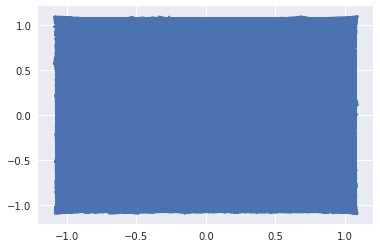

In [94]:
x = f['x']
y = f['y']
plt.plot(x, y)

(array([918386., 778093., 766018., 768985., 754374., 755672., 768244.,
        774389., 784889., 930950.]),
 array([-1.09795688e+00, -8.78172483e-01, -6.58388084e-01, -4.38603685e-01,
        -2.18819287e-01,  9.65112416e-04,  2.20749511e-01,  4.40533910e-01,
         6.60318309e-01,  8.80102708e-01,  1.09988711e+00]),
 <a list of 10 Patch objects>)

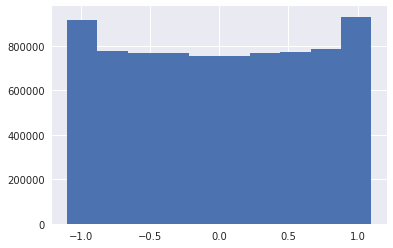

In [95]:
plt.hist(y)

## Tests

In [62]:
x0, y0 = x[100], y[100]

(-1.1, 1.1)

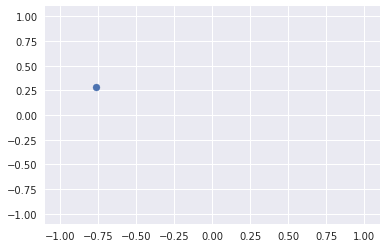

In [71]:
plt.scatter(x0,y0)
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])

In [73]:
dists = [box_size-x0, box_size-y0, box_size+x0, box_size+y0]
angles = np.arange(4)*np.pi/2
theta = angles[np.argmin(dists)]

In [74]:
theta

3.141592653589793

In [75]:
def min_dist_angle(position, direction, box_size):
    #which wall is it close to?
    x, y = position
    dists = [box_size-x, box_size-y, box_size+x, box_size+y]
    d_wall = np.min(dists)
    angles = np.arange(4)*np.pi/2
    theta = angles[np.argmin(dists)]
    a_wall = direction - theta
    a_wall = (a_wall + np.pi) % (2*np.pi) - np.pi
    return d_wall, a_wall

In [78]:
# random velocity samples
def generate_trajectory():
    v = np.random.rayleigh(b);
    #initialize variables
    position = np.zeros([samples+1, 2])
    head_dir = np.zeros(samples+1)
    turning = np.zeros(samples+1, dtype='bool')
    
    position[0] = np.random.uniform(-box_size,box_size, 2)
#     position[0] = np.zeros(2) + 1e-4
    head_dir[0] = np.random.uniform(0,2*np.pi)
    ego_v = np.zeros(samples+1)
    
    #generate sequence of random boosts and turns
    random_turn = np.random.normal(mu, sigma, samples+1)
    random_vel = np.random.rayleigh(b, samples+1)
    
    for i in range(1,samples+1):
        #If in border region, turn and slow down
        d_wall, a_wall = min_dist_angle(position[i-1], head_dir[i-1] % (2*np.pi), box_size)
        if d_wall < border_region and np.abs(a_wall) < np.pi/2:
            turning[i-1] = 1 
            turn_angle = np.sign(a_wall)* (np.pi/2 - np.abs(a_wall)) + dt*random_turn[i]
            v -= 0.25*v
        else:
            v = random_vel[i]
            turn_angle = dt*random_turn[i]
        #Take a step
        ego_v[i-1] = v*dt
        position[i] = position[i-1] + ego_v[i-1]*np.asarray([np.cos(head_dir[i-1]), np.sin(head_dir[i-1])])
        #Rotate head direction
        head_dir[i] = (head_dir[i-1] + turn_angle) 
    ang_velocity = np.diff(head_dir)
    theta_x, theta_y = np.cos(ang_velocity), np.sin(ang_velocity)
#     head_dir = (head_dir + np.pi) % (2*np.pi) - np.pi #Constrain head_dir to interval (-pi, pi)
    return position[:-1,0], position[:-1, 1], head_dir[:-1], ego_v[:-1], theta_x, theta_y, turning[:-1]

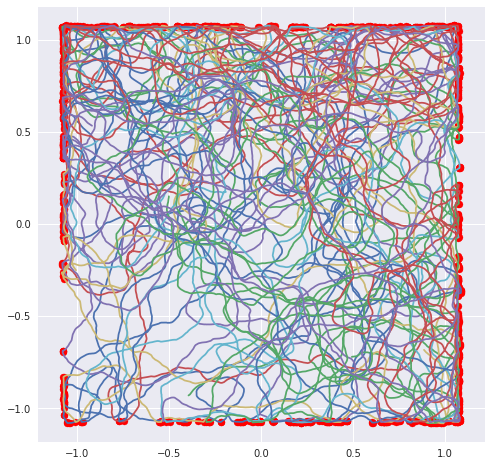

In [80]:
plt.figure(figsize=(8,8))
for i in range(10):
    sample_traj = generate_trajectory()
    x = sample_traj[0]
    y = sample_traj[1]
    turning = sample_traj[-1]
    plt.plot(x, y)
    plt.scatter(x[turning], y[turning], c='red')
    
plt.axis("equal")    
t = np.linspace(-np.pi, np.pi, 100)
# plt.plot(box_size*np.cos(t), box_size*np.sin(t))

In [82]:
#Generate dataset
num_trajectories = 800
x = []
y = []
head_dir = []
ego_v = []
theta_x = []
theta_y = []
i = 0
while len(x) < num_trajectories*samples - 1:
    new_traj = generate_trajectory()
    x = np.append(x, new_traj[0])
    y = np.append(y, new_traj[1])
    head_dir = np.append(head_dir, new_traj[2])
    ego_v = np.append(ego_v, new_traj[3])
    theta_x = np.append(theta_x, new_traj[4])
    theta_y = np.append(theta_y, new_traj[5])
    i += 1
    if i % 100 == 0:
        print(i)

100
200
300
400
500
600
700
800


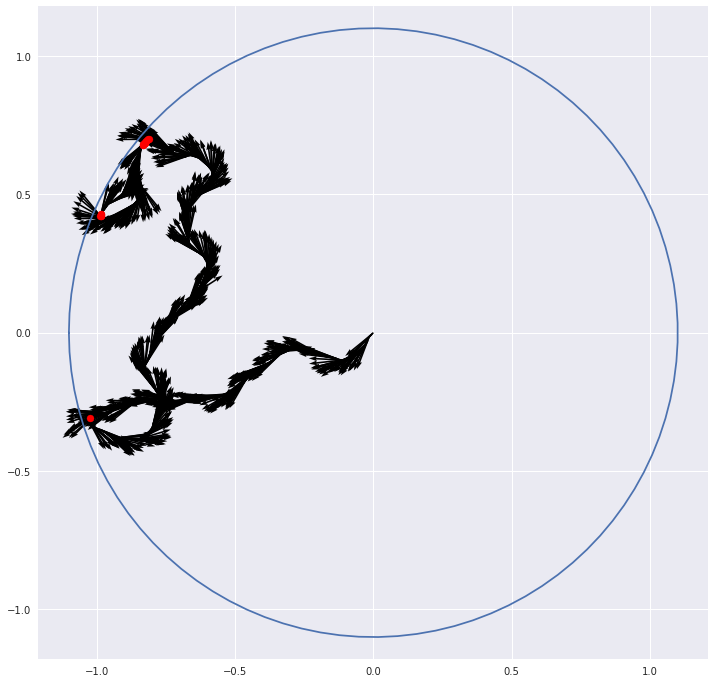

In [315]:
plt.figure(figsize=(12,12))
for i in range(1):
    sample_traj = generate_trajectory()
    x = sample_traj[0]
    y = sample_traj[1]
    ego_v = sample_traj[3]
    turning = sample_traj[-1]
    head_dir = sample_traj[2]
    plt.quiver(x, y, np.cos(head_dir), np.sin(head_dir), scale=20)
    plt.scatter(x[turning], y[turning], c='red')
    
plt.axis("equal")    
t = np.linspace(-np.pi, np.pi, 100)
plt.plot(box_size*np.cos(t), box_size*np.sin(t))

(array([1.47960e+05, 3.05428e+05, 2.85760e+05, 1.67844e+05, 6.83180e+04,
        1.98620e+04, 4.08000e+03, 6.81000e+02, 6.20000e+01, 5.00000e+00]),
 array([1.13277317e-11, 1.41143102e-03, 2.82286204e-03, 4.23429305e-03,
        5.64572406e-03, 7.05715507e-03, 8.46858608e-03, 9.88001710e-03,
        1.12914481e-02, 1.27028791e-02, 1.41143101e-02]),
 <a list of 10 Patch objects>)

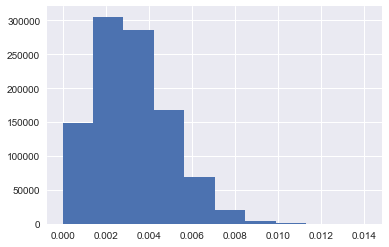

In [41]:
plt.hist(ego_v)

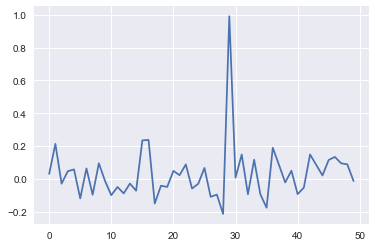

In [49]:
plt.plot(theta_y[350:400])

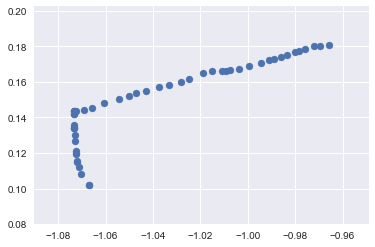

In [52]:
plt.scatter(x[350:400], y[350:400])

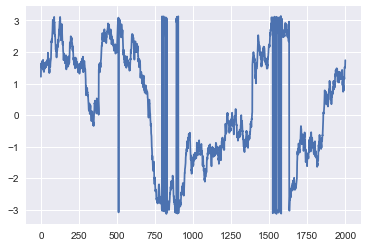

In [34]:
plt.plot(head_dir[:2000])

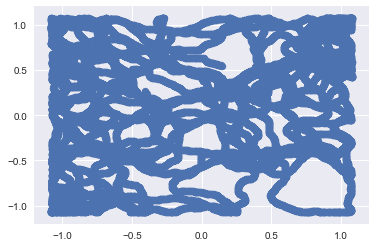

In [20]:
plt.scatter(x[:30000],y[:30000])

In [8]:
dt = 0.02 #time step increment (seconds)
samples = int(100/dt) #number of time points
box_size = 2.2 / 2 #meters
border_region = 0.03 #meters

position = np.zeros([samples+2, 2])
head_dir = np.zeros(samples+2)
turn_angle = 0

mu = 0
sigma = 5.76 #stdev rotation velocity (rads/sec)
b = 0.13 #forward velocity rayleigh dist scale (m/sec)

In [9]:
v = 0.2;

#initialize position and head direction randomly
position[0] = np.random.uniform(-box_size,box_size,2)
head_dir[0] = np.random.uniform(0,2*np.pi)

#generate sequence of random boosts and turns
random_turn = np.random.normal(mu, sigma, samples+2)
random_vel = np.random.rayleigh(b, samples+2)

for i in range(1,samples+2):
    #If in border region, turn and slow down
    d_wall, a_wall = min_dist_angle(position[i-1], head_dir[i-1] % (2*np.pi), box_size)
    if d_wall < border_region and np.abs(a_wall) < np.pi/2:
        turn_angle = np.sign(a_wall)*(np.pi/2 - np.abs(a_wall)) + dt*random_turn[i]
        v = 0.25*v
    else:
        v = random_vel[i]
        turn_angle = dt*random_turn[i]
    #Take a step
    ego_velocity[i-1] = v*dt
    position[i] = position[i-1] + ego_velocity[i-1]*np.asarray([np.cos(head_dir[i-1]), np.sin(head_dir[i-1])])
    #Rotate head direction
    head_dir[i] = (head_dir[i-1] + turn_angle) 
ang_velocity = np.diff(head_dir)
theta_x, theta_y = np.cos(ang_velocity), np.sin(ang_velocity)
head_dir = head_dir % (2*np.pi) #Constrain head_dir to interval (0, 2pi)
x = position[:,0]
y = position[:,1]

NameError: name 'ego_velocity' is not defined

In [37]:
idx = 4
#Can we reconstuct head direction from angular velocity?
head_dir_guess = head_dir[idx] + np.arctan(theta_y[idx]/theta_x[idx])
print('head dir guess = ' + str(head_dir_guess))
print('true head dir  = ' + str(head_dir[idx+1]))

#Can we reconstruct position from ego_v and angular velocity?
position_guess = position[idx] + ego_velocity[idx]*np.asarray([np.cos(head_dir[idx]), np.sin(head_dir[idx])])
print('position guess =' + str(position_guess))
print('true position = ' + str(position[idx+1]))

head dir guess = 3.051220736603194
true head dir  = 3.051220736603194
position guess =[-0.99076104 -0.46024195]
true position = [0. 0.]
